# Analysing the models

In this notebook, we use the simulations developed in the `modelling_the_data` notebook to investigate the characteristics of the battery.

We look at how the charge behaves over time, and also what initial charge is best. We also use the simulations to investigate the uncertainty associated with how long it takes the battery charge to either reach zero or max capacity.

In [1]:
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import special
import openturns as ot
from scipy.optimize import least_squares
from scipy.optimize import minimize
import warnings
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

from dynamic_containment import utils

plt.rcParams['text.usetex'] = False

The goal in this notebook is to investigate how dynamic containment can be used to complement a power grid when frequency deviates from 50 Hz in the grid changes.

We assume three different battery service powers for our service: 2 MW, 5 MW and 10 MW

First, assming white noise, following the discussion in the `modelling_the_data` notebook, we can calculate the expected rate of change of the charge for all three cases.

First, we set our parameters

In [2]:
service_powers = np.array([2, 5, 10])

max_cap = 4

max_charge_rate = 4.0
max_discharge_rate = 5.0

max_percent = max_charge_rate / service_powers
min_percent = max_discharge_rate / service_powers

alpha = 0.95/0.3
ccharge = 1 - 0.5 * alpha
    
delta_freq_max = (max_percent - ccharge) / alpha
delta_freq_min = -(min_percent - ccharge) / alpha

To calculate the level of white noise, we can use the data for our variance. Note, we are using the original data to cteate our simulations. In this notebook we do not cut the data, since missing data does not impact the covariance, but cutting and moving data around will likely affect it.

In [3]:
freq_table = utils.read_and_clean()

## The expectation value of the charge

We showed in the `modelling_the_data` notebook that the mean value of the frequency is consistent with 50 Hz.

We also demonstrated that assuming only Gaussian noise does a good job when predicting the expectation value of the charge of the battery when we ignore the limits of maximum capacity and an empty battery. We start with these assumptions that, since Gaussian noise requires only an estimate of the variance, and so is less impacted by uncertainty. The expected charge at time $t$ is then given by the recursive function

\begin{equation}
\left<C_t\right>=C_{t-1}+\Delta t\int^{\infty}_{-\infty} P_{\delta f}\left(\delta f\right|\sigma_{\delta f}^2)y(\delta f)\,\mathrm{d}\delta f
\end{equation}

where $\delta f=f-50$ Hz and $P_{\delta f}$ is a Normal distribution, with zero mean and variance $\sigma_{\delta f}^2$. $y(\delta f)$ is the peicewise linear function describing the response of the battery charge to $\delta f$, where we include the battery specifications. The charge at $t=0$, $C_0$ is the initial charge of the battery.

Here, we have made the assumption that $\delta f$ is unbound. Let's look at this assumption


In [4]:
print(f"For the uncut data, the standard deviation of the frequency is {np.round(freq_table.delta_freq.std(), 3)} Hz")

For the uncut data, the standard deviation of the frequency is 0.06 Hz


In [5]:
print("Respectively for the 2 MW, 5 MW and 10 MW service powers\n")
print("\tThe maximum charge rates are at %s percent, %s percent, and %s percent" % tuple(100*max_percent))
print(f"\tThese are when delta freq are {np.round(delta_freq_max, 2)} Hz\n")
print(f"\tThe maximum discharge rates are at %s percent, %s percent, and %s percent" % tuple(100*min_percent))
print(f"\tThese are when delta freq are {np.round(delta_freq_min, 2)} Hz")

Respectively for the 2 MW, 5 MW and 10 MW service powers

	The maximum charge rates are at 200.0 percent, 80.0 percent, and 40.0 percent
	These are when delta freq are [0.82 0.44 0.31] Hz

	The maximum discharge rates are at 250.0 percent, 100.0 percent, and 50.0 percent
	These are when delta freq are [-0.97 -0.5  -0.34] Hz


In [11]:
print(f"For the 10 MW case, where the maximum and minimum charge rates are at the lowest frequencies, we expect these charge rates to be hit, on average, every {np.round((1.0/(1.0 - utils.probability_tails(0.31/0.06, 0.34/0.06)))/86400, 2)} days") 

For the 10 MW case, where the maximum and minimum charge rates are at the lowest frequencies, we expect these charge rates to be hit, on average, every 91.54 days


The fact that some of the charge and discharge rates are greater than 100 % is an indication that the batter maximum charge and discharge rates are greater than the service power, and so these should be capped at 100 %.

For those cases where the rates are lower than 100%, these battery specifications cannot achieve the contract requirements, and these batteries should not be used. For the 5 MW case, where the maximum discharge rate is 100%, but the charge rate is 80%, this can fill the contract of a `low` service. The 10 MW case cannot fulfill the requirements of either service contract.

It is clear the magnitude of the minimum and maximum values of the frequencies in all cases is > 5 $\sigma_{\delta f}$, and so, when calculating the expectation of change in charge, it is reasonable to assume that the integral is unbound. However, it should be noted that, given the length of time that the battery runs, these frequencies may occur. Assuming normal distributed 

The integral above gives us the rate of change of charge

\begin{equation}
\frac{\mathrm{d}C}{\mathrm{d}t}=\int^{\infty}_{-\infty} P_{\delta f}\left(\delta f\right|\sigma_{\delta f}^2)y(\delta f)\,\mathrm{d}\delta f
\end{equation}

In [12]:
dcdt = np.array([
    utils.calc_gaussian_slope(freq_table.delta_freq.std(), sp)
    for sp in service_powers
])

This provides our estimate of the rate of change when we are not impacted by specifications as

In [13]:
print(f"The average rate of change of charges are {dcdt} MW")

The average rate of change of charges are [-3.23914437e-07 -8.09786093e-07 -1.61958050e-06] MW


For the 2 MW, 5 MW and 10 MW services respectively

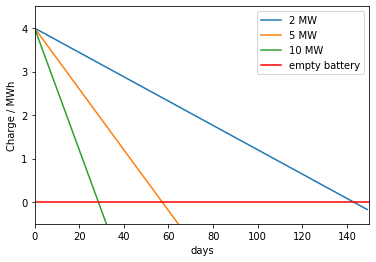

In [65]:
days = np.arange(150)
plt.plot(days, max_cap + days * (dcdt[0]*(3600.0 * 24.0)), label="2 MW")
plt.plot(days, max_cap + days * (dcdt[1]*(3600.0 * 24.0)), label="5 MW")
plt.plot(days, max_cap + days * (dcdt[2]*(3600.0 * 24.0)), label="10 MW")
plt.axhline(0, color='red', label="empty battery")
plt.ylabel("Charge / MWh")
plt.xlabel("days")
plt.xlim([0, 150])
plt.ylim([-0.5, max_cap + 0.5])
plt.legend()


## Incuding stochasticity

Now we follow the more realistic approach and generate a suite of simulations using the two-point correlation of the frequency data, which capatures temporal correlations.

We start by calculating the covariance matrix...

In [66]:
# Here, we calculate the covariance of the data as a function of temporal separation
real_space_cov = utils.temporal_covariance(freq_table, max_sep=10801, step=60)

  0%|          | 0/181 [00:00<?, ?it/s]

Next, we set the number of realisations and the time step to sample data at. We are currently using a fairly large time step to speed things up, but we verified that sampling at this scale should not cause significant increases in the uncertainty estimates due to the level of correlation at smaller scales.

In [67]:
# This is the number of realisations.
nreals = 200
# We sample the time (this may affect the noise properties)
time_step = 300

Now we create independent simulations for the three service powers. These simulate the how the charge changes over time, without considering the capacity of the battery. These will then be used to see where the different realisations hit capacity or reach zero. 

Note, we output the results for the `high`, `low` and `both` scenarios.

In [68]:
summaries, reals = utils.simulations_for_anaylsis(
    real_space_cov,
    service_powers,
    nreals,
    time_step,
    num_days=400,
    block_length=10800,
    max_discharge_rate=5,
    max_charge_rate=4,
    charge_efficiency=0.9
)

creating simulation for service power 2
creating simulation for service power 5
creating simulation for service power 10


We can select a date to look at the distribution of charges over the realisations. 

In [74]:
day = 10 # We will look at the start of day 10
sp = 2 # the service power to look at

keep_charge = int(day*86400/time_step)
samp_charge = []

for s in reals[sp]:
    
    samp_charge.append(float(reals[sp][s].iloc[keep_charge].culm_charge))

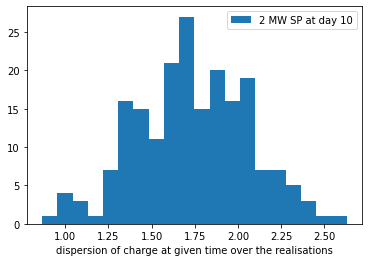

In [75]:
hist = plt.hist(0.5*max_cap + np.array(samp_charge), bins=20, label=f"{sp} MW SP at day {day}")
plt.xlabel("dispersion of charge at given time over the realisations")
plt.legend()

We will now find the intial charge that provides the longest expected time before fully charging or running out of charge

In [44]:
service_power = 10
num_charge_steps = 81
min_charge_lim = 2 # This is the lower bound of the optimisation
max_charge_lim = 4 # This is the upper bound of the optimisation

In [45]:
E_best, d_mean, E_arr = utils.find_E0_for_max_time(
    reals,
    service_power,
    max_cap=max_cap,
    min_charge_lim=min_charge_lim,
    max_charge_lim=max_charge_lim,
    num_charge_steps=num_charge_steps,
    poly_deg=8
)

This is a simple optimsation that uses polyfit to fit a curve to the mean termination date as a function of the intial charge, asshown below

In [46]:
res = np.polyfit(E_arr, d_mean, deg=8)

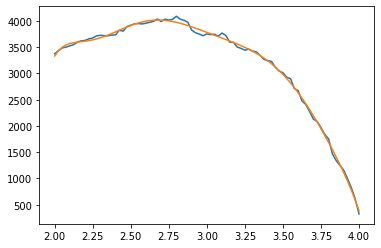

In [47]:
plt.plot(E_arr, d_mean)
plt.plot(E_arr, np.poly1d(res)(E_arr))

The best starting point is then

In [48]:
print(f"E_0 = {E_best[0]} MWh")

E_0 = 2.675 MWh


This gives the expected best date

In [49]:
dates = utils.max_date_func(E_best, reals, service_power, max_cap)*time_step /(3600.0 * 24.0)

print(f"{np.round(np.mean(dates), 2)} days")

14.01 days


Let's look at a histogram

Text(0.5, 0, 'days')

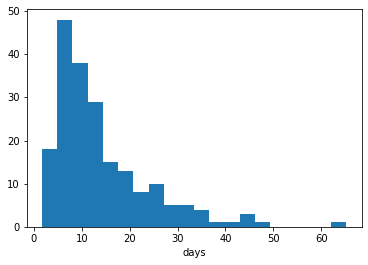

In [50]:
hist = plt.hist(dates, bins=20)
plt.xlabel("days")

We see a large dispersion in the simulations.

Lets run this for all three service powers

In [59]:
results = utils.service_power_loop(
    reals,
    service_powers,
    max_cap=max_cap,
    time_step=time_step,
    min_charge_lim=min_charge_lim,
    max_charge_lim=max_charge_lim,
    num_charge_steps=num_charge_steps,
    poly_deg=8,
    verbose=True,
)

For service power 2 MW
	The expected date of termination is 119.42 days
	The 95.0% confidence interval is 32.82 - 209.1 days
	With initial charge = 3.5250000000000004 MWh
For service power 5 MW
	The expected date of termination is 41.47 days
	The 95.0% confidence interval is 4.07 - 97.11 days
	With initial charge = 3.2 MWh
For service power 10 MW
	The expected date of termination is 14.01 days
	The 95.0% confidence interval is 3.22 - 43.87 days
	With initial charge = 2.675 MWh


In [61]:
results = utils.service_power_loop(
    reals,
    service_powers,
    max_cap=max_cap*2.0,
    time_step=time_step,
    min_charge_lim=min_charge_lim*2.0,
    max_charge_lim=max_charge_lim*2.0,
    num_charge_steps=num_charge_steps,
    poly_deg=8,
    verbose=True,
)

For service power 2 MW
	The expected date of termination is 347441.71 days
	The 95.0% confidence interval is 2.16 - 376.35 days
	With initial charge = 7.75 MWh
For service power 5 MW
	The expected date of termination is 95.79 days
	The 95.0% confidence interval is 11.16 - 167.78 days
	With initial charge = 7.0 MWh
For service power 10 MW
	The expected date of termination is 37.31 days
	The 95.0% confidence interval is 5.87 - 84.73 days
	With initial charge = 6.4 MWh


In [53]:
results = utils.service_power_loop(
    reals,
    service_powers,
    max_cap=max_cap,
    time_step=time_step,
    min_charge_lim=min_charge_lim,
    max_charge_lim=max_charge_lim,
    num_charge_steps=num_charge_steps,
    service='low'
)

For service power 2 MW
	The expected date of termination is 14.31 days
	The 95.0% confidence interval is 12.91 - 15.69 days
	With initial charge = 4 MWh
For service power 5 MW
	The expected date of termination is 5.74 days
	The 95.0% confidence interval is 4.92 - 6.63 days
	With initial charge = 4 MWh
For service power 10 MW
	The expected date of termination is 2.85 days
	The 95.0% confidence interval is 2.32 - 3.59 days
	With initial charge = 4 MWh


In [54]:
results = utils.service_power_loop(
    reals,
    service_powers,
    max_cap=max_cap,
    time_step=time_step,
    min_charge_lim=min_charge_lim,
    max_charge_lim=max_charge_lim,
    num_charge_steps=num_charge_steps,
    service='high'
)

For service power 2 MW
	The expected date of termination is 15.87 days
	The 95.0% confidence interval is 14.59 - 17.47 days
	With initial charge = 0 MWh
For service power 5 MW
	The expected date of termination is 6.34 days
	The 95.0% confidence interval is 5.51 - 7.28 days
	With initial charge = 0 MWh
For service power 10 MW
	The expected date of termination is 3.25 days
	The 95.0% confidence interval is 2.63 - 3.95 days
	With initial charge = 0 MWh


{2: {'E_best': array([7.75]),
  'exp_date': 347441.7053298612,
  'date_lower': 2.1631944444444446,
  'date_higher': 376.34722222222223,
  'dates': array([5.28125000e+00, 2.73864583e+02, 2.18013889e+02, 4.30902778e+00,
         1.95770833e+02, 2.70927083e+02, 2.56597222e+02, 2.41118056e+02,
         2.73149306e+02, 2.88562500e+02, 3.30527778e+02, 2.09947917e+02,
         2.73100694e+02, 2.21173611e+02, 2.28708333e+02, 1.71697917e+02,
         3.78131944e+02, 2.58097222e+02, 2.45371528e+02, 2.72159722e+02,
         6.22916667e+00, 2.16909722e+02, 3.67732639e+02, 3.23906250e+02,
         3.30427083e+02, 3.45027778e+02, 2.29802083e+02, 1.41666667e+00,
         3.14309028e+02, 3.12121528e+02, 3.14579861e+02, 7.73611111e+00,
         1.28611111e+01, 2.89750000e+02, 2.32097222e+02, 1.88947917e+02,
         2.75944444e+02, 2.08673611e+02, 2.44250000e+02, 2.96100694e+02,
         1.35902778e+01, 2.24684028e+02, 2.95875000e+02, 3.47222222e+07,
         2.50715278e+02, 2.26065972e+02, 3.76347222e